In [2]:
import librosa.display
import pandas as pd
import scipy.io.wavfile

from utils.signal import get_segment, plot_signal, plot_spectra, stft_audio,calc_mfcc, get_segment_stats, envelope, get_total_segment_stats, get_total_audio_stats
from utils.annotation import get_meta_annotation, get_simplified_meta_annotation, get_simplified_annotation
import IPython.display as ipd
from utils.randomforest import run_randomforest
from utils.features import get_boxplot_by_species, get_scree_plot
import seaborn as sns
from hidden_Markov_Model import *
import matplotlib.pyplot as plt

# 1. Pre-Processing

## 1.1. get features for a single file

首先将一小段鸟鸣转化成我们所需要的结构化的特征。之后大批的数据处理过程是在此基础上，循环每一个文件完成的。

第一步，读取注解文件。

In [3]:
FILE_PATH  = './dryad/annotation_Files/Recording_1/Recording_1_Segment_04.Table.1.selections.txt'
r1_annotation = get_simplified_annotation(FILE_PATH, filter=True, overlap_percent=0.1)
r1_annotation.head()

,selection,View,Channel,start,end,low_freq,high_freq,species,duration,is_isolate,overlap_percent,date
0,1,Spectrogram 1,1,3.098305,3.274278,2896.1,4411.5,EATO,0.175973,True,-19.123989,1
1,2,Spectrogram 1,1,6.639586,6.832434,2761.4,4310.4,EATO,0.192847,True,-32.193227,1
2,3,Spectrogram 1,1,9.675502,9.849064,2761.4,4647.2,EATO,0.173563,True,-37.811919,1
3,4,Spectrogram 1,1,13.568730,13.725418,2761.4,4546.2,EATO,0.156688,True,-45.589321,1
4,5,Spectrogram 1,1,17.149072,17.344329,2761.4,4478.8,EATO,0.195258,True,-35.682788,1


第二步，读取音频文件，并选取其中的一个鸟鸣片段作为示例。

In [4]:
r1, Fs = librosa.load('./dryad/wav_Files/Recording_1/Recording_1_Segment_04.wav')
r1 = get_segment(signal=r1, annotation=r1_annotation,Fs=Fs)
r1_0 = r1[0]
#ipd.Audio(r1_0, rate=Fs)

第三步，将这一鸟鸣片段转化成声学特征，即12个MFCC系数，过零率zcr，频谱质心sc，贷款bw，衰减截止频率srf，以及注解文件所包含的信息。

In [5]:
%run ./utils/signal.py
feature_seg = get_segment_stats(signal=r1_0, Fs=Fs, frame_length=512,
                                hop_length=256,mfcc_order=0,
                                annotation=r1_annotation[0:1],
                                mean=False,filter=True)
feature_seg.head()

,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,mfcc_12,zcr,sc,bw,srf,selection,low_freq,high_freq,date,species
0,-646.430814,6.696095,-24.306837,-14.941837,-16.913761,-10.615375,-3.304481,-1.679255,-25.387072,-5.580959,...,-14.892721,0.181641,4639.427845,3051.471999,9776.074219,1,2896.1,4411.5,1,EATO
1,-577.733320,16.936584,-2.364689,4.050717,-16.238062,-4.228176,10.074824,1.134345,-11.994897,-0.405950,...,2.557178,0.333984,4563.730930,3027.442390,9776.074219,1,2896.1,4411.5,1,EATO
2,-587.350555,3.100136,-18.435314,-0.814114,-18.846130,-19.901440,4.893982,-3.210669,-18.501262,2.901266,...,-3.323010,0.320312,4576.847391,2928.377241,9776.074219,1,2896.1,4411.5,1,EATO
3,-589.289296,-1.000739,-29.021105,2.031575,-6.501949,-7.824974,10.985939,-1.100648,-18.496765,11.483185,...,5.112219,0.318359,4480.163438,2796.703076,9603.808594,1,2896.1,4411.5,1,EATO
4,-573.147127,8.652197,-27.334459,15.425290,-14.797558,-13.919037,6.070009,-0.962277,-4.983158,28.764465,...,2.315237,0.324219,4138.484199,2615.042632,9216.210938,1,2896.1,4411.5,1,EATO


最后一步，将整个5分钟的音频文件中所有鸟鸣片段转化成对对应的声学特征，得到结构化的数据。

In [24]:
%run ./utils/signal.py
feature_seg_col = pd.DataFrame(columns=feature_seg.columns)
feature_seg = get_total_segment_stats(signal=r1,
                              Fs=Fs,
                              mfcc_order=0,
                              annotation=r1_annotation,
                              frame_length=512,
                              hop_length=256,
                              feature_seg=feature_seg_col,
                              env=False,
                              thres=0.01,
                              mean=False,
                              filter=True)

## 1.2. GET features for the whole file folder

在这里，由于我们之后要讨论鸟鸣片段的重合对于分类器的影响，因此在数据处理时就分类生成重叠比为<0.01, 0.01-0.1, 0.1-0.3, 0.3-0.5, 0.5-0.7, 0.7-1的多个数据集。

In [8]:
AUDIO_PATH = './dryad/wav_Files'
overlap_percentage = [0.01, 0.1, 0.3, 0.5, 0.7, 1]
for o_p in overlap_percentage:
    total_feature = get_total_audio_stats(audio_path=AUDIO_PATH,
                                  mfcc_order=0, frame_length=512, hop_length=256,
                                  feature_seg=feature_seg_col,
                                  env=False, thres=0.0005,
                                  mean=False,signal_filter=True,
                                  annotation_filter=True, overlap_percent=o_p)
    total_feature.to_csv('total_feature-%s.csv'%str(o_p), sep='\t', encoding='utf-8', index=False)

## 1.3 filter the final dataset

经过descriptive analysis可知，有时会收集到一些较少出现的鸟类，即稀疏数据。由于这部分鸟鸣在数据中没有代表性，因此我们希望仅选择注解多且较为纯净的鸟鸣片段。这也就是说，我们可以硬性规定，每种鸟的鸟鸣片段应当大于5，且在此标准下，选择鸟鸣片段最多的8种鸟类。

In [ ]:
# 判断某种鸟类是否含有大于5段的鸟鸣片段
def __is_seg_per_species(feature,set_seg_per_species):
    mid = pd.DataFrame(feature[['species','segment']].drop_duplicates().groupby('species').size()).reset_index()
    mid = mid.rename(columns={0:'seg_count'})
    return any(mid['seg_count']<set_seg_per_species)

In [383]:
final_seg = []
total_feature = pd.read_csv('total_feature-1.csv',sep='\t')
total_feature = total_feature.drop(columns=['Unnamed: 0','low_freq','high_freq','date'])

is_seg_per_species = __is_seg_per_species(total_feature, 5)
seg_lower_bound = 190


while is_seg_per_species:
    seg_lower_bound = seg_lower_bound - 10

    clean_sparse_seg = total_feature.groupby(['species', 'segment']).size()
    clean_sparse_seg = pd.DataFrame(clean_sparse_seg).reset_index().rename(columns={0: 'Count'})
    clean_sparse_seg = clean_sparse_seg[clean_sparse_seg['Count']>seg_lower_bound]['segment'].to_list()
    total_feature_mid = total_feature[total_feature['segment'].isin(clean_sparse_seg)]

    final_species = total_feature_mid[['species','segment']].groupby('species').size().sort_values(ascending=False).head(8).reset_index()['species'].values
    total_feature_mid = total_feature_mid[total_feature_mid['species'].isin(final_species)]
    is_seg_per_species = __is_seg_per_species(total_feature_mid, 5)


total_feature = total_feature_mid
final_seg.append(total_feature['segment'].drop_duplicates().to_list())
total_feature = total_feature[~total_feature['segment'].isin(final_seg)]
# total_feature['date'] = total_feature['date'].apply(lambda elem: int(elem))

In [279]:
import os
from tqdm.notebook import tqdm as tqdm

pd.options.mode.chained_assignment = None
AUDIO_PATH = './dryad/wav_Files'
overlap_percentage = [0.3, 0.5, 0.7, 1]
final_seg=[]

for o_p in tqdm(overlap_percentage):

    total_feature = pd.read_csv('total_feature-%s.csv'%str(o_p),sep='\t')
    total_feature = total_feature.drop(columns='Unnamed: 0')
    total_feature = total_feature[~total_feature['segment'].isin(final_seg)]

    is_seg_per_species = __is_seg_per_species(total_feature, 5)
    seg_lower_bound = 190
    while is_seg_per_species:
        seg_lower_bound = seg_lower_bound - 10

        clean_sparse_seg = total_feature.groupby(['species', 'segment']).size()
        clean_sparse_seg = pd.DataFrame(clean_sparse_seg).reset_index().rename(columns={0: 'Count'})
        clean_sparse_seg = clean_sparse_seg[clean_sparse_seg['Count']>seg_lower_bound]['segment'].to_list()
        total_feature_mid = total_feature[total_feature['segment'].isin(clean_sparse_seg)]

        final_species = total_feature_mid[['species','segment']].groupby('species').size().sort_values(ascending=False).head(8).reset_index()['species'].values

        total_feature_mid = total_feature_mid[total_feature_mid['species'].isin(final_species)]
        is_seg_per_species = __is_seg_per_species(total_feature_mid, 5)

    total_feature = total_feature_mid
    final_seg.append(total_feature['segment'].drop_duplicates().to_list())
    total_feature['date'] = total_feature['date'].apply(lambda elem: int(elem))

    mid_target_audio_clip = total_feature[['low_freq', 'high_freq', 'species']].drop_duplicates().reset_index()
    target_audio_clip = pd.DataFrame(columns=['recording','selection'])

    for i in range(mid_target_audio_clip.shape[0]):
        mid2 = bird_annotation.loc[(bird_annotation['low_freq']==mid_target_audio_clip['low_freq'][i]) & (bird_annotation['high_freq']==mid_target_audio_clip['high_freq'][i]) & (bird_annotation['species']==mid_target_audio_clip['species'][i])][['recording','selection','duration']]
        target_audio_clip = pd.concat([target_audio_clip,mid2],axis=0, ignore_index=True)

    target_audio_clip = target_audio_clip.reset_index(drop=True)
    target_audio_clip = target_audio_clip[target_audio_clip['duration']<5].reset_index(drop=True)

    file_folder = target_audio_clip['recording'].apply(lambda x: x.split('_Segment')[0])
    mid = target_audio_clip.shift(1)
    feature_CNN = pd.DataFrame(columns=total_feature.columns)

    for i in tqdm(range(len(target_audio_clip))):
        audio_filepath = os.path.join(AUDIO_PATH, file_folder[i], target_audio_clip['recording'][i]) + '.wav'
        annotation_filepath = audio_filepath.replace('wav_Files', 'annotation_Files')
        annotation_filepath = annotation_filepath.replace('.wav', '.Table.1.selections.txt')

        if mid['recording'][i] != target_audio_clip['recording'][i]:
            audio, Fs = librosa.load(audio_filepath)
            annotation = get_simplified_annotation(annotation_filepath, filter=False)
            audio = get_segment(signal=audio, annotation=annotation, Fs=Fs)

        target_seg = audio[target_audio_clip['selection'][i] - 1]

        pre_padding_sample = int(round((5 * Fs - len(target_seg))/ 2 , 0))
        after_padding_sample = 5 * Fs - pre_padding_sample - len(target_seg)
        target_seg = np.pad(target_seg, (int(pre_padding_sample), int(after_padding_sample)), mode='constant')

        target_annotation = annotation[(target_audio_clip['selection'][i] - 1):(target_audio_clip['selection'][i])]
        target_annotation['selection'] = i
        feature = get_segment_stats(signal=target_seg, Fs=Fs, frame_length=512, hop_length=256,
                                mfcc_order=0,
                                annotation=target_annotation, mean=False, filter=True)
        feature_CNN = pd.concat([feature_CNN, feature],ignore_index=True)

    feature_CNN.to_csv('feature_CNN-%s.csv'%str(o_p), sep='\t', encoding='utf-8', index=False)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/532 [00:00<?, ?it/s]

  0%|          | 0/962 [00:00<?, ?it/s]

In [102]:
#pd.options.mode.chained_assignment = None
#target_annotation = annotation[(target_audio_clip['selection'][i] - 1):(target_audio_clip['selection'][i])]
target_audio_clip

,recording,selection,duration
0,Recording_1_Segment_30,6,2.611363
1,Recording_1_Segment_30,15,2.563636
2,Recording_1_Segment_30,72,2.775000
3,Recording_1_Segment_30,84,2.468182
4,Recording_1_Segment_30,96,3.511363
...,...,...,...
957,Recording_3_Segment_01,278,3.389291
958,Recording_3_Segment_01,301,2.251492
959,Recording_3_Segment_01,336,2.564869
960,Recording_3_Segment_01,350,3.553211


In [187]:
target_seg = audio[target_audio_clip['selection'][i] - 1]
pre_padding_sample = int(round((5 * Fs - len(target_seg))/ 2 , 0))
after_padding_sample = 5 * Fs - pre_padding_sample - len(target_seg)
target_seg = np.pad(target_seg, (int(pre_padding_sample), int(after_padding_sample)), mode='constant')
target_annotation = annotation[(target_audio_clip['selection'][i] - 1):(target_audio_clip['selection'][i])]
feature = get_segment_stats(signal=target_seg, Fs=Fs, frame_length=512, hop_length=256,
                                mfcc_order=0,
                                annotation=target_annotation, mean=False, filter=True)
feature

,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,mfcc_11,mfcc_12,zcr,sc,bw,srf,segment,low_freq,high_freq,species
0,-859.178766,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,357,1529.2,3341.5,NOCA
1,-621.339681,-47.255720,-8.416223,6.026917,-40.575164,6.755024,-40.924215,15.601733,-16.298379,-0.382820,...,-3.861127,19.121995,0.121094,5598.637254,2072.051444,8527.148438,357,1529.2,3341.5,NOCA
2,-446.064604,-79.476667,-18.527158,20.845085,-33.704548,-2.778130,-28.038725,38.899762,-26.337682,21.904061,...,13.674117,10.105776,0.408203,5836.140681,1863.047229,8397.949219,357,1529.2,3341.5,NOCA
3,-425.483692,-47.706457,-23.627264,7.861381,-19.221064,11.088132,-25.220288,20.881875,-19.040204,25.434599,...,-0.625472,15.638434,0.576172,5552.923612,2212.193934,8656.347656,357,1529.2,3341.5,NOCA
4,-451.082655,-66.690019,-21.099310,28.747556,-21.602283,9.463611,-23.844948,29.994546,-13.890543,19.001849,...,5.126489,14.278182,0.548828,5605.406245,2008.942888,8397.949219,357,1529.2,3341.5,NOCA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,-431.936508,-30.076524,-67.603471,14.387680,-1.096106,11.208015,-5.402356,-11.022637,-4.726371,-1.550925,...,3.750424,2.568326,0.273438,3886.700574,2305.963591,8871.679688,357,1529.2,3341.5,NOCA
427,-429.898744,-13.959221,-46.195240,25.638384,-8.127852,-1.651746,-5.311331,-8.109815,-4.304108,12.856843,...,-12.325075,-3.434555,0.265625,3960.011542,2341.845193,8957.812500,357,1529.2,3341.5,NOCA
428,-431.721873,-15.940455,-57.728740,31.471039,-6.380116,-7.077721,-12.928176,-8.614329,0.612451,3.155133,...,-7.952892,-11.985075,0.238281,3719.099778,2153.127310,8527.148438,357,1529.2,3341.5,NOCA
429,-421.763282,-16.192939,-61.854773,26.980809,-7.070314,2.114542,4.824622,-7.531876,-7.706045,8.103504,...,-7.651743,-19.298453,0.158203,3709.845908,2182.634720,8785.546875,357,1529.2,3341.5,NOCA


In [107]:
total_feature = pd.read_csv('feature_CNN-0.01.csv',sep='\t')
total_feature['segment'].drop_duplicates()

0          0
431        1
862        2
1293       3
1724       4
        ... 
79735    185
80166    186
80597    187
81028    188
81459    189
Name: segment, Length: 190, dtype: int64

# 2. Modelling

## 2.1 Tree-based Methods

### 随机森林

对每一个重叠比的数据集重复5次试验。这里仅选择了accuracy作为测量。

In [71]:
randomforest_accuracy = []
randomforest_importance = []

acc,importance = run_randomforest(total_feature.drop(columns='segment'),random_state=30,n_estimators=100)
randomforest_accuracy.append(acc)
randomforest_importance.append(importance)

Accuracy= 0.9984663370693448


In [98]:
randomforest_accuracy

[0.9951796271032287,
 0.9958099614786781,
 0.9953305374205543,
 0.992721245315653,
 0.9935223033795707,
 0.9966802992260503]

对于不同重叠比的数据，看一下不同变量的重要性是否会发生变化。由图可知，最重要的两个变量是来自于注解文件中的频率极值。

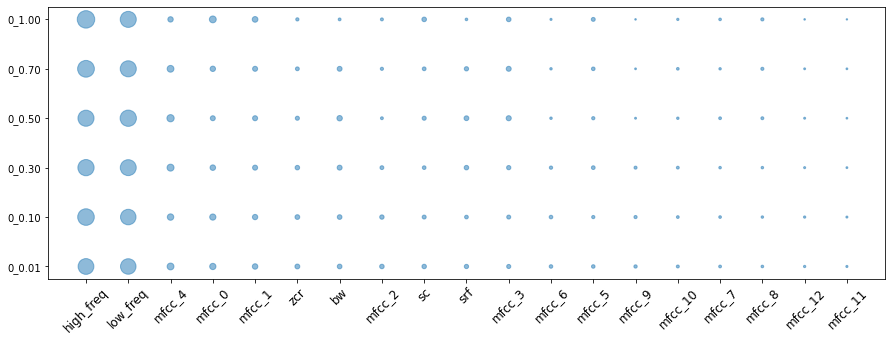

In [104]:
overlap_list = [0.01, 0.1, 0.3, 0.5, 0.7, 1]
r_i = pd.DataFrame(randomforest_importance[0])
for i in range(1,6):
    r_i = r_i.join(pd.DataFrame(randomforest_importance[i]),lsuffix='_%.2f'%overlap_list[i-1], rsuffix='_%.2f'%overlap_list[i])

import itertools
r_i2= pd.DataFrame(list(itertools.product(r_i.index,r_i.columns))).rename(columns={0:'var',1:'overlap'})

r_i2['importance'] = r_i2.apply(lambda row: mid.loc[row['var']][row['overlap']], axis=1)
r_i2['importance']= 2*r_i2['importance']

plt.figure(figsize=(15,5))
plt.scatter(data=r_i2, x="var", y="overlap",s='importance', alpha=0.5)
_ = plt.xticks(rotation=45, fontsize=12)

从上图可以看到，频率极值的重要性一直很高。那么我们具体看一下，随着重叠比增高，频率极值的重要性是否增加了。答案是是的。这与我们的直觉一致：随着重叠比增加，提取的信号特征质量下降，更多需要依靠注解里的信息。

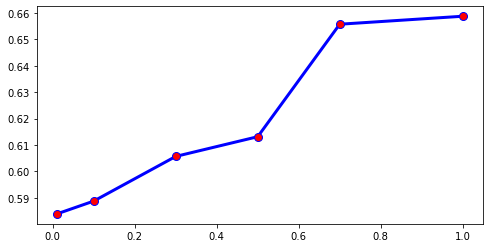

In [72]:
mid = [randomforest_importance[i].loc['high_freq']+randomforest_importance[i].loc['low_freq'] for i in range(len(randomforest_importance))]
plt.figure(figsize=(8,4))
plt.plot(overlap_list,mid,color = 'blue', linewidth = 3, marker='o', markerfacecolor='red', markersize=8)

### XGBoost

In [355]:
xgboost_accuracy = []
xgboost_importance = []

In [386]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

species_list = total_feature['species'].drop_duplicates().to_list()
species_to_int_dict = {y:x for y,x in zip(species_list,range(len(species_list)))}

mid = total_feature.drop(columns=['segment'])
mid['species'] = mid['species'].apply(lambda elem: species_to_int_dict[elem])
X_mid, y_mid =mid.iloc[:,:-1],mid.iloc[:,-1]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_mid, y_mid, test_size=0.3, random_state=123)
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
a = accuracy_score(y_test, predictions)
xgboost_accuracy.append(a)
print("Accuracy: %.2f%%" % (a * 100.0))
xgboost_importance.append(model.feature_importances_)

Accuracy: 81.32%


In [387]:
xgboost_accuracy

[0.7830832196452933,
 0.7830832196452933,
 0.7878624045414611,
 0.7967919062648623,
 0.8140674545978668,
 0.778194732962541,
 0.8131907954339554]

对XGBoost重复上述分析过程，发现随着重叠比增加，不同变量的重要性发生了明显的变化。

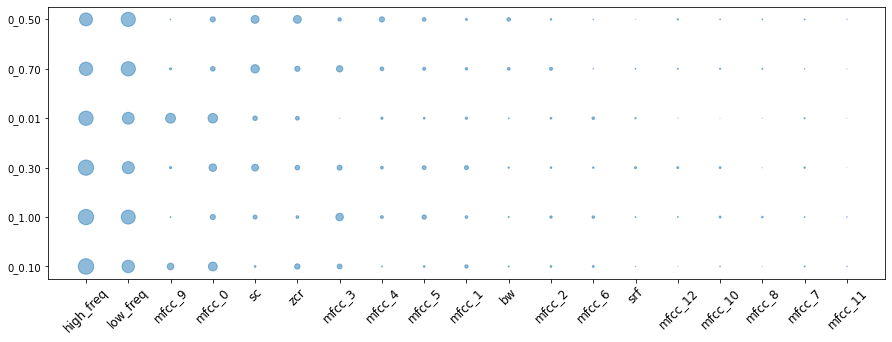

In [145]:
overlap_list = [0.01, 0.1, 0.3, 0.5, 0.7, 1]
mid = pd.DataFrame(xgboost_importance[0].copy())
for i in range(1,6):
    mid = mid.join(pd.DataFrame(xgboost_importance[i]),lsuffix='_%.2f'%overlap_list[i-1], rsuffix='_%.2f'%overlap_list[i])

mid['var'] = total_feature.drop(columns=['segment','species']).columns
mid = mid.set_index('var')

import itertools
mid2= pd.DataFrame(list(itertools.product(mid.index,mid.columns))).rename(columns={0:'var',1:'overlap'})
mid2['importance'] = mid2.apply(lambda row: mid.loc[row['var']][row['overlap']], axis=1)

mid2['importance']= 600*mid2['importance']
mid2 = mid2.sort_values(by='importance', ascending=False)

plt.figure(figsize=(15,5))
plt.scatter(data=mid2, x="var", y="overlap",s='importance', alpha=0.5)
_ = plt.xticks(rotation=45, fontsize=12)

XGBoost对频率范围的依赖与重叠比并没有明确的正向关系。

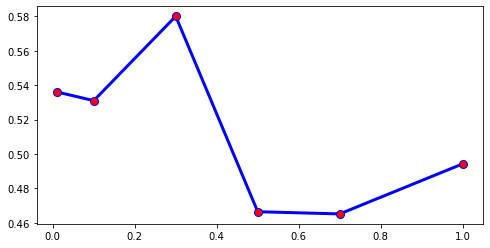

In [106]:
mid = [xgboost_importance[i][18]+xgboost_importance[i][19] for i in range(len(xgboost_importance))]
plt.figure(figsize=(8,4))
plt.plot(overlap_list,mid,color = 'blue', linewidth = 3, marker='o', markerfacecolor='red', markersize=8)

In [161]:
xgboost_accuracy

[0.9938947767740712,
 0.9918790617131596,
 0.9940057033114125,
 0.9921266064668146,
 0.9898207136202252,
 0.9869058937228434]

## 2.2 HMM

HMM中的状态可以理解为某种鸟鸣模式。以橙顶杜鹃OVEN为例，将鸣叫按照时间分成不同状态，可以描述鸟鸣之间的间隔、短促鸟鸣音节与更长的鸟鸣音节组成的鸟鸣模式。

In [7]:
from hmmlearn import hmm
import copy
from collections import defaultdict
from sklearn.metrics import confusion_matrix
import warnings
import glob
import numpy as np
import pandas as pd
import random
warnings.filterwarnings("ignore", category=DeprecationWarning)

def GHMM_train(dataset, states = 4, trials = 10,cov = "diag",max_iter=1000, randomSeed = 100, min_cov = 1e-3):
    rndNum = 10
    prob = -np.inf
    best_g = None
    score = 0
    np.random.seed(randomSeed)
    random_state = np.random.random(trials)
    for i in range(len(random_state)):
        state = int(random_state[i]*1000)
        g = hmm.GaussianHMM(n_components=states, covariance_type = cov, n_iter=max_iter, min_covar = min_cov)
        g.fit(dataset)
        score = g.score(dataset)
        if score > prob:
            prob = score
            best_g = copy.deepcopy(g)
    return best_g

def GHMM_evaluate(testset, GMMmodel):
    #test set is a list of sets of name-date collections
    #GMMmodel is a dictionary of test data
    truth = []
    pred = []
    for dataset in testset:
        truth.append(dataset[0])
        test_score = -np.inf
        pred_name = None
        for modelName, model in GMMmodel.items():
            score = model.score(dataset[1])
            if score > test_score:
                test_score = score
                pred_name = modelName
        pred.append(pred_name)
    label = []
    for item in truth:
        if item not in label:
            label.append(item)
    matrix = confusion_matrix(truth, pred, labels=label)
    return matrix,truth,pred

def get_HMM(feature, states,cov = "diag", clean_sparse=True, train_percent=0.7):

    test_feature = feature.copy()
    segment_list = test_feature['segment'].drop_duplicates().to_list()

    train_list = []
    train_percent = train_percent
    train_segment_list = random.sample(segment_list, int(train_percent * len(segment_list)))
    selected_feature = test_feature[test_feature['segment'].isin(train_segment_list)]
    for seg in train_segment_list:
        selected_segment = selected_feature[selected_feature['segment'] == seg]
        train_list.append((str(selected_segment['species'].drop_duplicates().values),
                           selected_segment.drop(columns=['species', 'segment'])))

    modelDict = dict()
    for dataset in train_list:
        model = GHMM_train(dataset=dataset[1], states=states, trials=1, cov=cov, max_iter=100, randomSeed=120,
                           min_cov=1e-5)
        modelDict[dataset[0]] = model

    test_list = []
    selected_feature = test_feature[~test_feature['segment'].isin(train_segment_list)]
    test_segment_list = selected_feature['segment'].drop_duplicates().to_list()
    for seg in test_segment_list:
        selected_segment = selected_feature[selected_feature['segment'] == seg]
        test_list.append((str(selected_segment['species'].drop_duplicates().values),
                          selected_segment.drop(columns=['species', 'segment'])))

    return GHMM_evaluate(test_list,modelDict)

In [36]:
cofusion_mat, truth, pred = get_HMM(feature=total_feature,states=12, cov='spherical', clean_sparse=False)
"""
    covariance_type : string
        String describing the type of covariance parameters to use.  Must be
        one of 'spherical' (each state has its own single variance that applies
        for all components), 'tied' (the same general covariance matrix applies
        to all states), 'diag' (the same diagonal covariance matrix applies to
        all states), 'full' (each state has its own general covariance matrix).
        Defaults to 'diag'.
"""

"\n    covariance_type : string\n        String describing the type of covariance parameters to use.  Must be\n        one of 'spherical' (each state has its own single variance that applies\n        for all components), 'tied' (the same general covariance matrix applies\n        to all states), 'diag' (the same diagonal covariance matrix applies to\n        all states), 'full' (each state has its own general covariance matrix).\n        Defaults to 'diag'.\n"

In [43]:
# overlap = 0.2
from tqdm import tqdm
accuracy = []
hmm_accuracy = []
for i in tqdm(range(1,8)):
    accuracy_iter = []
    for j in tqdm(range(5)):
        cofusion_mat, truth, pred = get_HMM(feature=total_feature,states=i, cov='spherical')
        accuracy_iter.append(np.trace(cofusion_mat) / np.sum(cofusion_mat))
    accuracy.append(np.mean(accuracy_iter))
hmm_accuracy.append(accuracy)

100%|██████████| 7/7 [29:40<00:00, 254.39s/it]


In [39]:
[max(hmm_accuracy[i]) for i in range(len(hmm_accuracy))]

[0.7209090909090908,
 0.752,
 0.7076923076923076,
 0.7522935779816513,
 0.6654545454545454]

In [120]:
pd.DataFrame(np.amax(pd.DataFrame(hmm_accuracy),axis=1)).to_clipboard()

对于超参状态数，看一下不同状态数下准确度的变化。选取9个为佳。

Text(0, 0.5, 'Accuracy')

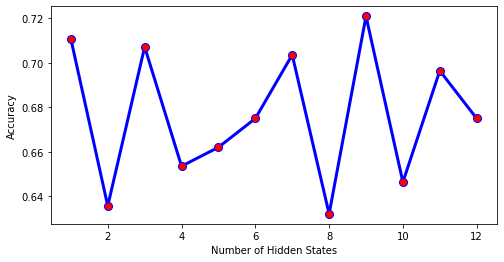

In [10]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(1,13),accuracy,color = 'blue', linewidth = 3, marker='o', markerfacecolor='red', markersize=8)
plt.xlabel("Number of Hidden States")
plt.ylabel("Accuracy")

对于不包含日期的数据集，当重叠比上升时，HMM 的分类准确度出现大幅波动更为剧烈，并且即使是最合适的状态数，分类准确度仍然不如重叠比较低时的情形。 对于重叠比在 1%-10%的数据集，预测的波动性比重叠比 0%-1%的数据集所对应的预 测波动小 0.01 左右，这可能是由于随机性带来的。

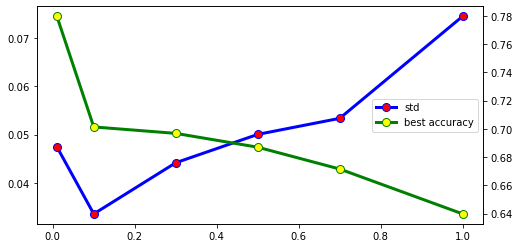

In [202]:
mid = [np.std(hmm_accuracy[i]) for i in range(len(hmm_accuracy)) ]
mid2 = [max(hmm_accuracy[i]) for i in range(len(hmm_accuracy))]
fig, ax1 = plt.subplots(figsize=(8,4))
ax2 = ax1.twinx()
lns1 = ax1.plot(overlap_list,mid,color = 'blue', linewidth = 3, marker='o', markerfacecolor='red', markersize=8, label='std')
lns2 = ax2.plot(overlap_list,mid2,color = 'green', linewidth = 3, marker='o', markerfacecolor='yellow', markersize=8, label='best accuracy')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=5)

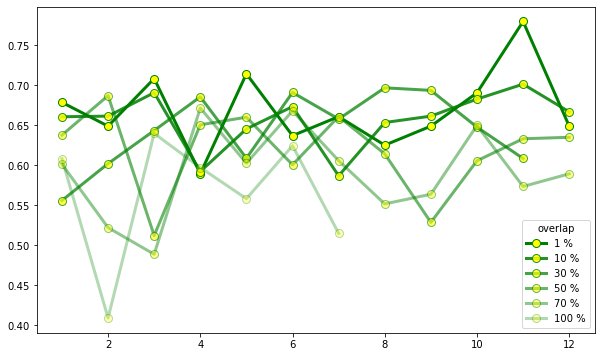

In [195]:
overlap_list = [0.01, 0.1, 0.3, 0.5, 0.7, 1]
plt.figure(figsize=(10,6))
for i in range(6):
    plt.plot(np.arange(1,len(hmm_accuracy[i])+1),hmm_accuracy[i],color = 'green', linewidth = 3, marker='o', markerfacecolor='yellow', markersize=8,alpha=1-0.14*i, label = '%d %%'%(100*overlap_list[i]))
plt.legend(loc='best', title = 'overlap')

对于包含日期的数据集，上述规律仅体现在50%-70%重叠比的数据集与70%-100%重叠比的数据集的对比中。可能是因为增加了 date 变量使得分类更稳健了。但是总的 来说，最佳准确率对应标准差最低的仍然是重叠比最低(1%)的数据集。因此，增加 HMM 预测准确度和稳健性的重要条件，是保证鸟鸣片段的单一性。

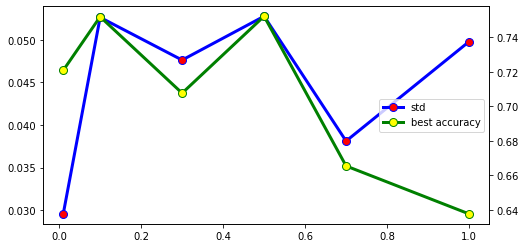

In [45]:
mid = [np.std(hmm_accuracy[i]) for i in range(len(hmm_accuracy)) ]
mid2 = [max(hmm_accuracy[i]) for i in range(len(hmm_accuracy))]
fig, ax1 = plt.subplots(figsize=(8,4))
ax2 = ax1.twinx()
lns1 = ax1.plot(overlap_list,mid,color = 'blue', linewidth = 3, marker='o', markerfacecolor='red', markersize=8, label='std')
lns2 = ax2.plot(overlap_list,mid2,color = 'green', linewidth = 3, marker='o', markerfacecolor='yellow', markersize=8, label='best accuracy')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=5)

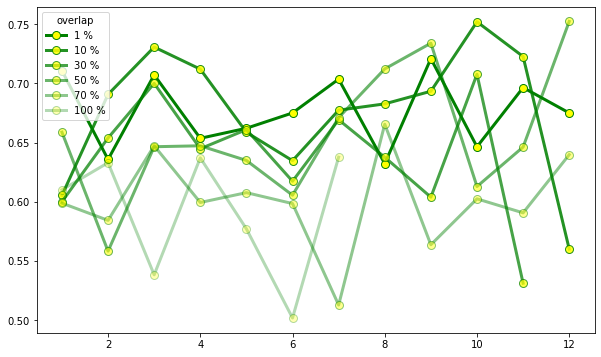

In [44]:
overlap_list = [0.01, 0.1, 0.3, 0.5, 0.7, 1]
plt.figure(figsize=(10,6))
for i in range(6):
    plt.plot(np.arange(1,len(hmm_accuracy[i])+1),hmm_accuracy[i],color = 'green', linewidth = 3, marker='o', markerfacecolor='yellow', markersize=8,alpha=1-0.14*i, label = '%d %%'%(100*overlap_list[i]))
plt.legend(loc='best', title = 'overlap')

## 2.3 CNN

In [247]:
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D, Flatten, LSTM, MaxPool2D
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import np_utils
from tqdm.notebook import tqdm
from keras.callbacks import EarlyStopping

def min_of_X(new_min, old_min):
    return [min(x, y) for x,y in zip(new_min,old_min)]
def max_of_X(new_min, old_min):
    return [max(x, y) for x,y in zip(new_min,old_min)]


def build_rand_feat(feature, species_to_int_dict, train_percent):
    X = []
    y = []
    #X_test = []
    #y_test = []
    train_seg = []
    segment_list = feature['segment'].drop_duplicates().to_list()
    n_seg = int(len(segment_list)) # train_percent *
    _min, _max = np.empty(20), np.empty(20)
    for _ in tqdm(range(n_seg)):
        selected_segment = np.random.choice(segment_list) # 抽一个乐器
        train_seg.append(selected_segment)
        selected_feature = feature[feature['segment']==selected_segment]
        X_sample = selected_feature.drop(columns=['segment','species'])
        #_min = min_of_X(np.amin(X_sample),_min)
        #_max = max_of_X(np.amax(X_sample),_max)
        X.append(X_sample if config.mode=='conv' else X_sample.T)
        y.append(species_to_int_dict[selected_feature['species'].drop_duplicates().values[0]]) # classes 是一个map classes to int的list,比如EATO的index=1，label=选取文件的classes
    X, y = np.array(X), np.array(y)
    #_min, _max = np.array(_min),np.array(_max)
    #X = (X - _min) / (_max - _min)
    """
    test_seg = [x for x in segment_list if x not in train_seg]

    for i in tqdm(test_seg):
        selected_feature = feature[feature['segment']==i]
        X_sample = selected_feature.drop(columns=['segment','species'])
        #_min = min_of_X(np.amin(X_sample),_min)
        #_max = max_of_X(np.amax(X_sample),_max)
        X_test.append(X_sample if config.mode=='conv' else X_sample.T)
        y_test.append(species_to_int_dict[feature[~feature['segment'].isin(train_seg)]['species'].drop_duplicates().values[0]])

    X_test, y_test = np.array(X_test), np.array(y_test)
    #_min, _max = np.array(_min),np.array(_max)
    #X_test = (X_test - _min) / (_max - _min)
    """
    if config.mode == 'conv':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
        #X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
    elif config.mode == 'time':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
        #X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])
    y =  np_utils.to_categorical(y, num_classes=10) # num_classes：乐器数
    #y_test = np_utils.to_categorical(y_test, num_classes=10)

    return X,y
#X_test, y_test

def get_conv_model():

    model=Sequential()
    model.add(Conv2D(16, (5,5), activation='relu',strides=(2,2),
                     padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (5,5), activation='relu',strides=(2,2),
                     padding='same'))
    model.add(Conv2D(64, (5, 5), activation='relu', strides=(2, 2),
                     padding='same', input_shape=input_shape))
    model.add(Conv2D(128, (5, 5), activation='relu', strides=(2, 2),
                     padding='same'))
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.8))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

class Config:
    def __init__(self, mode='conv', nfilt=26, nfeat=13, nfft=512, rate=32000):
        self.mode = mode
        self.nfilt = nfilt
        self.nfeat = nfeat
        self.rate = rate
        self.nfft = nfft
        self.step= int(rate/10) # frame_length?


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

Epoch 1/100
18/18 [==============================] - 2s 69ms/step - loss: 35.5052 - accuracy: 0.2711 - val_loss: 1.5262 - val_accuracy: 0.6667
Epoch 2/100
18/18 [==============================] - 1s 47ms/step - loss: 2.8799 - accuracy: 0.4155 - val_loss: 1.4433 - val_accuracy: 0.5556
Epoch 3/100
18/18 [==============================] - 1s 46ms/step - loss: 1.9133 - accuracy: 0.4401 - val_loss: 1.5954 - val_accuracy: 0.4583
Epoch 4/100
18/18 [==============================] - 1s 44ms/step - loss: 1.6635 - accuracy: 0.5070 - val_loss: 1.3562 - val_accuracy: 0.5972
Epoch 5/100
18/18 [==============================] - 1s 47ms/step - loss: 1.5004 - accuracy: 0.5070 - val_loss: 1.2637 - val_accuracy: 0.5833
Epoch 6/100
18/18 [==============================] - 1s 45ms/step - loss: 1.3498 - accuracy: 0.5563 - val_loss: 1.0757 - val_accuracy: 0.6944
Epoch 7/100
18/18 [==============================] - 1s 47ms/step - loss: 1.1844 - accuracy: 0.6338 - val_loss: 1.0112 - val_accuracy: 0.6944
Epoch

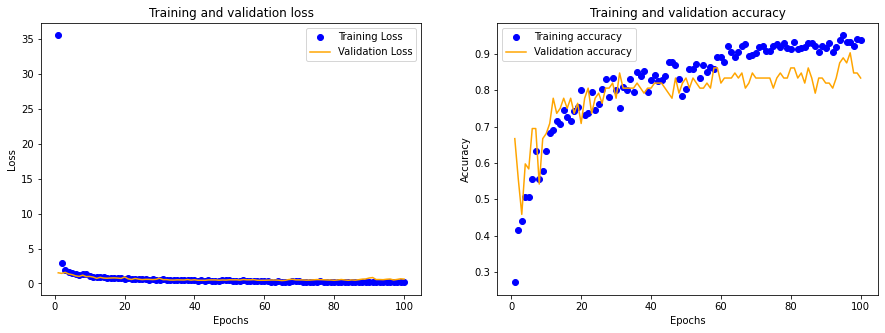

In [390]:
overlap_percentage = [0.01, 0.1, 0.3, 0.5, 0.7, 1]
max_accuracy_val = []
for o_p in tqdm(overlap_percentage):
    config = Config(mode='conv')
    total_feature = pd.read_csv('feature_CNN-%s.csv'%o_p,sep='\t')
    total_feature = total_feature.drop(columns=['date','low_freq','high_freq'])
    species_list = total_feature['species'].drop_duplicates().to_list()
    species_to_int_dict = {y:x for y,x in zip(species_list,range(len(species_list)))}

    if config.mode == 'conv':
        X, y = build_rand_feat(feature=total_feature,species_to_int_dict=species_to_int_dict, train_percent=0.8)
        # , X_test, y_test
        y_flat = np.argmax(y, axis=1)
        input_shape = (X.shape[1], X.shape[2], 1)
        model = get_conv_model()
    """
elif config.mode == 'time':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2])
    model = get_recurrent_model()
    """
#early_stopping = EarlyStopping(monitor='val_loss', patience=2)
# , validation_data=(X_test, y_test), callbacks=[early_stopping]

    model_CNN = model.fit(X,y, epochs=100, batch_size=16,validation_split=0.2)
    history_dict=model_CNN.history

    loss_values=history_dict['loss']
    acc_values=history_dict['accuracy']
    val_loss_values = history_dict['val_loss']
    val_acc_values=history_dict['val_accuracy']
    epochs=range(1,101)
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
    ax1.plot(epochs,loss_values,'bo',label='Training Loss')
    ax1.plot(epochs,val_loss_values,'orange', label='Validation Loss')
    ax1.set_title('Training and validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax2.plot(epochs,acc_values,'bo', label='Training accuracy')
    ax2.plot(epochs,val_acc_values,'orange',label='Validation accuracy')
    ax2.set_title('Training and validation accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    fig.savefig('CNN-%s_wDate.png'%o_p)
    max_accuracy_val.append(sorted(val_acc_values)[-1:])

In [391]:
max_accuracy_val

[[0.9027777910232544]]

对于 CNN 来说，分类准确率更重要的影响因素是数据量。对于重叠比在 0-1%的 数据，仅含有 190 条鸟鸣片段，因此分类效果最差。对于重叠比在10%-30%的数据， 含有350条鸟鸣片段，准确率达到98%。重叠比在 30%-50%的数据，含有 356 条鸟 鸣片段，与重叠比在 10%-30%的数据量相仿。此我们可以看到，此时分类的准确率有所降低，大概在 95%左右。

因此，笔者推测，如果从数据集中去掉注解文件中的信息(low_freq, high_freq, date)，CNN 的分类效果也很好。
